# Data downloading into ASDF and computing cross correlation functions 

In this notebook, we show the basic steps of NoisePy for 1) downloading seismic data using [ObsPy](https://github.com/obspy/obspy/wiki) functions (`get_station` and `get_waveform`) and saving them into ASDF file, and 2) computing cross correlation functions. As you will find through the practise, apart from the data downloading and data loading processes (sections 0-3), the rest of the notebook is essentionally the same to the one shown in the other notebook of `cross_correlation_from_sac`. If you would like to use the NoisePy to deal with SAC/mSEED files at your local disk or any other format that can be ready by ObsPy, we recommend you look at the other notebook first. 

The steps to compuate cross correlation functions as illustrated in this notebook are:  
* Download Z-component data from 2 TA stations, pre-process the data (remove gaps, downsample etc) and save them into one ASDF file
* Read the ASDF file with the first station to be source and the other as the receiver
* Break the continous data into small segments with overlaps
* Perform Fourier Transform to convert signals into frequency-domain
* Calculate cross correlation functions between the small time segments and choose to stack (substack) the cross correlation function of each segment and return to time domain
* Save the correlation function into an ASDF file

More details on the descriptions of data processing, parameters for different cross correlation method and performance of NoisePy can be found in the online [documentations](https://noise-python.readthedocs.io/en/latest/) and the manuscript.

`Jiang, C. and Denolle, M. NoisePy: a new high-performance python tool for seismic ambient noise seismology. In prep for _Seismological Research Letter_.`



Chengxin Jiang & Marine Denolle

Department of Earth and Planetary Science

Harvard University

November 2019

## Building env for NoisePy

Before running this notebook, make sure that you have created and activated the conda env made for NoisePy. If not, you can create one using command lines below (note that jupyter is installed with the command lines here in order to run this notebook). 

```python
conda create -n noisepy -c conda-forge python=3.7.3 numpy=1.16.2 numba pandas pycwt jupyter mpi4py=3.0.1
conda activate noisepy
pip install obspy pyasdf 
git clone https://github.com/mdenolle/NoisePy.git
```

Then you need to activate this notebook with the newly built NoisePy env by invoking the jupyter with the following command line.

```python
jupyter notebook
```

Now we can begin to load the modules needed for downloading part first. 

In [1]:
import sys
import time
import obspy
import pyasdf
import os, glob
import numpy as np
import pandas as pd
import noise_module
from obspy import UTCDateTime
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client

## 0. Settings for data request

Here we download one day of continous data (Z component) for 2 TA stations located west of the Boston city, and we do not remove instrument response (set `rm_resp` to `inv` if you want to use the inventory for instrumental removal), downsample it to 1 Hz and filter it to 0.05-0.4 Hz in the pre-processing. Note that in NoisePy, the way of specifying network, station and channel are slightly different and here just show one example. NoisePy also accepts using a compliated station list for data downloading in S1. 

In [2]:
# download parameters
client    = Client('IRIS')                                      # client/data center. see https://docs.obspy.org/packages/obspy.clients.fdsn.html for a list
samp_freq = 1                                                   # targeted sampling rate at X samples per seconds 
rm_resp   = 'no'                                                # select 'no' to not remove response and use 'inv','spectrum','RESP', or 'polozeros' to remove response
respdir   = './'                                                # directory where resp files are located (required if rm_resp is neither 'no' nor 'inv')
freqmin   = 0.05                                                # pre filtering frequency bandwidth
freqmax   = 0.4                                                   # note this cannot exceed Nquist freq                         

chan = ['BHZ','BHZ']                                            # channel for each station
net  = ['TA','TA']                                              # network for each station 
sta  = ['K62A','K63A']                                          # station (using a station list is way either compared to specifying stations one by one)
start_date = ["2014_01_01_0_0_0"]                               # start date of download
end_date   = ["2014_01_02_0_0_0"]                               # end date of download
inc_hours  = 24                                                 # length of data for each request (in hour)
nsta       = len(sta)

# save prepro parameters into a dic
prepro_para = {'rm_resp':rm_resp,'respdir':respdir,'freqmin':freqmin,'freqmax':freqmax,'samp_freq':samp_freq,'start_date':\
    start_date,'end_date':end_date,'inc_hours':inc_hours}

# convert time info to UTC format
starttime = obspy.UTCDateTime(start_date[0])       
endtime   = obspy.UTCDateTime(end_date[0])

# another format of time info needed for get_station and get_waveform
s1,s2 = noise_module.get_event_list(start_date[0],end_date[0],inc_hours)
date_info = {'starttime':starttime,'endtime':endtime} 


## 1. Download data and save into ASDF file

Note that this step might take a few seconds for data download. 

In [3]:
# write into ASDF file: using start and end time as file name
ff=os.path.join('./',s1+'T'+s2+'.h5')
with pyasdf.ASDFDataSet(ff,mpi=False,compression="gzip-3",mode='w') as ds:

    # loop through each station
    for ista in range(nsta):

        # get inventory for each station
        try:
            sta_inv = client.get_stations(network=net[ista],station=sta[ista],\
                location='*',starttime=s1,endtime=s2,level="response")
        except Exception as e:
            print(e);continue

        # add the inventory into ASDF        
        try:
            ds.add_stationxml(sta_inv) 
        except Exception: 
            pass   

        try:
            # get data
            tr = client.get_waveforms(network=net[ista],station=sta[ista],\
                channel=chan[ista],location='*',starttime=s1,endtime=s2)
        except Exception as e:
            print(e,'for',sta[ista]);continue
            
        # preprocess to clean data  
        print('working on station '+sta[ista])
        tr = noise_module.preprocess_raw(tr,sta_inv,prepro_para,date_info)

        if len(tr):
            new_tags = '{0:s}_00'.format(chan[ista].lower())
            ds.add_waveforms(tr,tag=new_tags)


working on station K62A
working on station K63A


## 2.Setup basic parameters for data-processing and cross correlation

Next we setup the parameters used for processing the noise data and for later cross correlation computation. As you can find from section below, there are many parameters needed for the computation, which are associated with the input data, options for different processing procedures, cross correlation methods and some tuning parameters. Brief descriptions of each parameter are followed by the variable assignment, but note that more details on this can be found in documentations.  

In [4]:
sfile = glob.glob('./*h5')      # find sac files
if not len(sfile):
    raise ValueError('Abort! At least 2 sac files are needed!')
outpath = './'                     # output dir

# parameters of fft_cc
cc_len    = 1800                    # window length (sec) to cut daily data into small segments
step      = 450                     # overlapping (sec) between the sliding window
smooth_N  = 10                      # number of points to be smoothed for running-mean average (time-domain)
dt        = 1/samp_freq             # sampling time intervals of the data: in real case it reads from data directly
inc_hours = 24                      # basic length (hour) of the continous noise data        

freq_norm   = 'rma'                 # rma-> running mean average for frequency-domain normalization
time_norm   = 'no'                  # no-> no time-domain normalization; other options are 'rma' for running-mean and 'one-bit'
cc_method   = 'xcorr'               # xcorr-> pure cross correlation; other option is 'decon'
substack       = False              # sub-stack daily cross-correlation or not
substack_len   = cc_len             # how long to stack over: need to be multiples of cc_len
smoothspect_N  = 10                 # number of points to be smoothed for running-mean average (freq-domain)

# cross-correlation parameters
maxlag       = 200                  # time lag (sec) for the cross correlation functions
max_over_std = 10                   # amplitude therahold to remove segments of spurious phases 

# group parameters into a dict
fc_para={'samp_freq':samp_freq,'dt':dt,'cc_len':cc_len,'step':step,'freq_norm':freq_norm,'time_norm':time_norm,\
    'cc_method':cc_method,'maxlag':maxlag,'max_over_std':max_over_std,'inc_hours':inc_hours,'smooth_N':smooth_N,\
    'freqmin':freqmin,'freqmax':freqmax,'smoothspect_N':smoothspect_N,'substack':substack,\
    'substack_len':substack_len}

## 3. Load source data

We take the first station in the ASDF file as the source and the other as the receiver. The raw noise data is stored in the $waveform$ structure of the ASDF file and it uses $network.station$ and $channel\_location$ as the two tags for each station. You would notice that most of the following steps are similar to the ones in the other notebook. 

In [5]:
# read source and some meta info
with pyasdf.ASDFDataSet(sfile[0],mode='r') as ds:
    
    # station list
    sta_list = ds.waveforms.list()
    print('source of %s and receiver %s'%(sta_list[0],sta_list[1]))
    
    # channels for each station
    all_tags = ds.waveforms[sta_list[0]].get_waveform_tags()
    
    # get the source trace
    tr_source = ds.waveforms[sta_list[0]][all_tags[0]]
    
    # read inventory
    inv1 = ds.waveforms[sta_list[0]]['StationXML']
    
    # read station info from inventory
    ssta,snet,slon,slat,elv,loc = noise_module.sta_info_from_inv(inv1)

# cut source traces into small segments and make statistics
trace_stdS,dataS_t,dataS = noise_module.cut_trace_make_statis(fc_para,tr_source)

# do fft to freq-domain
source_white = noise_module.noise_processing(fc_para,dataS)
source_white = np.conjugate(source_white)

# num of frequency data
Nfft = source_white.shape[1];Nfft2 = Nfft//2

# find the right index of good signals
sou_ind = np.where((trace_stdS<max_over_std)&(trace_stdS>0)&(np.isnan(trace_stdS)==0))[0]

source of TA.K62A and receiver TA.K63A


## 4. Load receiver data

In [6]:
# read receiver and some meta info
with pyasdf.ASDFDataSet(sfile[0],mode='r') as ds:
    
    # channels for each station
    all_tags = ds.waveforms[sta_list[1]].get_waveform_tags()
    
    # get the source trace
    tr_receiver = ds.waveforms[sta_list[1]][all_tags[0]]
    
    # read inventory
    inv1 = ds.waveforms[sta_list[1]]['StationXML']
    
    # read station info from inventory
    rsta,rnet,rlon,rlat,elv,loc = noise_module.sta_info_from_inv(inv1)

# work out distance between source and receiver
dist,azi,baz = obspy.geodetics.base.gps2dist_azimuth(slat,slon,rlat,rlon)

# cut source traces into small segments and make statistics
trace_stdR,dataR_t,dataR = noise_module.cut_trace_make_statis(fc_para,tr_receiver)

# do fft to freq-domain
receiver_white = noise_module.noise_processing(fc_para,dataR)

# find the right index of good signals
rec_ind = np.where((trace_stdR<max_over_std)&(trace_stdR>0)&(np.isnan(trace_stdR)==0))[0]

## 5. Perform cross correlation

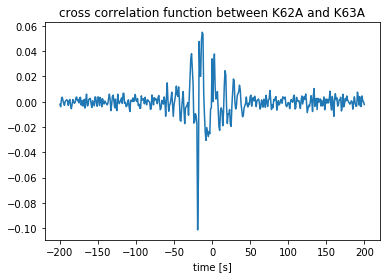

In [10]:
# find the segments of good data for both source and receiver
bb=np.intersect1d(sou_ind,rec_ind)
if len(bb)==0:raise ValueError('Abort! no good data in overlap')

# do cross correlation
corr_day,t_corr,n_corr = noise_module.correlate(source_white[bb,:Nfft2],receiver_white[bb,:Nfft2],fc_para,Nfft,dataS_t)

# plot the waveform
tvec = np.arange(-maxlag,maxlag+dt,dt)
plt.figure()
plt.plot(tvec,corr_day)
plt.xlabel('time [s]')
plt.title('cross correlation function between %s and %s'%(ssta,rsta))
plt.show()

## 6. Save cross correlation data into ASDF file

Though we only have one station pair, we can try to save it into the ASDF file. We save the cross correlation data into the auxiliary structure of ASDF, which has two dimentions (data_type and path). In this example, we use the station and network name of the source and receiver station to define the $data\_type$ and use the channel names to define the $path$. The two tags are chose because the two-dimention variable are enough to define any cross component of the cross correlation functions for any station pairs. 

In [11]:
cc_h5 = 'cc_example_TA.h5'         
with pyasdf.ASDFDataSet(cc_h5,mpi=False,mode='w') as ccf_ds:
    # location info 
    coor = {'lonS':slon,'latS':slat,'lonR':rlon,'latR':rlat}
    # cross component
    comp = tr_source[0].stats.channel[-1]+tr_receiver[0].stats.channel[-1]
    # parameters to be saved into ASDF
    parameters = noise_module.cc_parameters(fc_para,coor,t_corr,n_corr,comp)

    # data_type name as source-receiver pair
    data_type = tr_source[0].stats.network+'.'+tr_source[0].stats.station+'_'+tr_receiver[0].stats.network+'.'+tr_receiver[0].stats.station
    # path name as cross component
    path = comp
    # command to save data and parameters into asdf structure
    ccf_ds.add_auxiliary_data(data=corr_day, data_type=data_type, path=path, parameters=parameters)


## 7. Read the ASDF file

Finally, we want to read the cross correlation function we just saved. To retrive the data, we simply need the two tags we just created for the auxiliary structure in ASDF, which are $data\_type$ and $path$. Note that we do not necessarily need to know the two parameters beforehand, because we can simply get the two parameters from reading the file. You will see how we do it from the codes below.  

['TA.K62A_TA.K63A'] ['ZZ']


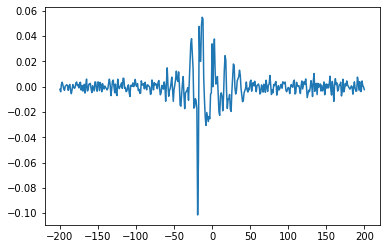

In [13]:
with pyasdf.ASDFDataSet(cc_h5,mode='r') as ds:
    data_type = ds.auxiliary_data.list()
    path = ds.auxiliary_data[data_type[0]].list()
    print(data_type,path)
    
    data = ds.auxiliary_data[data_type[0]][path[0]].data[:]
    para = ds.auxiliary_data[data_type[0]][path[0]].parameters
    
    # plot the waveform again
    plt.plot(tvec,data)

## The end.

We hope you enjoy it! Most of the core steps of NoisePy are included here for illustration, and NoisePy is simply adding more loops for source and receiver stations and use some tricks (including embedding parallel functionality) to speed up the general performance. 